Imports + Settings

In [1]:
import os
import numpy as np
import pandas as pd
import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

print("Notebook initialized ✔")


Notebook initialized ✔


MOUNT DRIVE + LOAD DATA

In [3]:
from google.colab import drive
drive.mount('/content/drive')

BASE = "/content/drive/MyDrive/MP"
EVENTS_PATH   = f"{BASE}/events.csv"
PICKS_PATH    = f"{BASE}/picks.csv"
STATIONS_PATH = f"{BASE}/stations.csv"

# Load files
events   = pd.read_csv(EVENTS_PATH, dtype={"event_id": str})
picks    = pd.read_csv(PICKS_PATH, dtype={"event_id": str})
stations = pd.read_csv(STATIONS_PATH, dtype={"station_code": str})

print("Loaded:")
print("events :", events.shape)
print("picks  :", picks.shape)
print("stations:", stations.shape)


Mounted at /content/drive
Loaded:
events : (983649, 3)
picks  : (10110885, 3)
stations: (1789, 3)


PARAMETERS

In [4]:
MAX_STATIONS = 15
MIN_STATIONS = 4
RANDOM_STATE = 42

print(f"Model: supports up to {MAX_STATIONS} stations (min required = {MIN_STATIONS})")


Model: supports up to 15 stations (min required = 4)


MERGE PICKS + STATIONS

In [5]:
picks_st = picks.merge(stations, on="station_code", how="inner")

picks_st = picks_st.sort_values(
    ["event_id","station_code","p_arrival_time_sec"]
).drop_duplicates(subset=["event_id","station_code"], keep="first")

print("Merged picks+stations:", picks_st.shape)


Merged picks+stations: (150476, 5)


BUILD FEATURES (dt, lat, lon FOR 15 STATIONS)

In [6]:
def build_event_features(g):
    g = g.sort_values("p_arrival_time_sec").copy()
    if len(g) < MIN_STATIONS:
        return None

    t0 = g["p_arrival_time_sec"].iloc[0]
    g["dt"] = g["p_arrival_time_sec"] - t0

    g = g.iloc[:MAX_STATIONS].reset_index(drop=True)

    row = {"event_id": g["event_id"].iloc[0]}
    for i, r in g.iterrows():
        k = i + 1
        row[f"dt_{k}"] = float(r["dt"])
        row[f"sta_lat_{k}"] = float(r["sta_lat"])
        row[f"sta_lon_{k}"] = float(r["sta_lon"])
    return row

rows = []
skipped = 0

for eid, g in tqdm(picks_st.groupby("event_id")):
    r = build_event_features(g)
    if r is None:
        skipped += 1
        continue
    rows.append(r)

print("Events used:", len(rows), "Skipped:", skipped)

features_df = pd.DataFrame(rows)
print("Feature table:", features_df.shape)


100%|██████████| 54671/54671 [00:37<00:00, 1466.16it/s]


Events used: 16392 Skipped: 38279
Feature table: (16392, 28)


MERGE WITH EVENTS (TARGET LAT/LON)

In [7]:
events["event_id"] = events["event_id"].astype(str)
features_df["event_id"] = features_df["event_id"].astype(str)

df = features_df.merge(events[["event_id","eq_lat","eq_lon"]], on="event_id", how="inner")
print("Merged features+events:", df.shape)


Merged features+events: (16393, 30)


CLEAN + PAD TO 15 STATIONS

In [8]:
req = []
for k in range(1, MIN_STATIONS+1):
    req += [f"dt_{k}", f"sta_lat_{k}", f"sta_lon_{k}"]

df = df.dropna(subset=req)
print("After enforcing min stations:", df.shape)

full_cols = []
for k in range(1, MAX_STATIONS+1):
    full_cols += [f"dt_{k}", f"sta_lat_{k}", f"sta_lon_{k}"]

for c in full_cols:
    if c not in df.columns:
        df[c] = 0.0

df[full_cols] = df[full_cols].fillna(0.0)

X = df[full_cols].astype(float)
y = df[["eq_lat","eq_lon"]].astype(float)

print("Final X:", X.shape, " y:", y.shape)


After enforcing min stations: (16393, 30)
Final X: (16393, 45)  y: (16393, 2)


TRAIN/TEST SPLIT

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (13114, 45) Test: (3279, 45)


TRAIN RANDOM FOREST (MULTI-OUTPUT)

In [10]:
model = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
)

print("Training model… Please wait.")
model.fit(X_train, Y_train)
print("Training complete ✔")


Training model… Please wait.
Training complete ✔


✅ FULL EVALUATION CODE (MAE + ACCURACY)

MAE (km): 2.829861382578854
Median Absolute Error (km): 1.0942794844339856
Best Case Error (km): 0.009225928602870257
Worst Case Error (km): 94.51187832765612
Accuracy (within 5 km): 84.23%

Accuracy at different distance thresholds:
Within 5 km: 84.23%
Within 10 km: 95.36%
Within 20 km: 98.51%


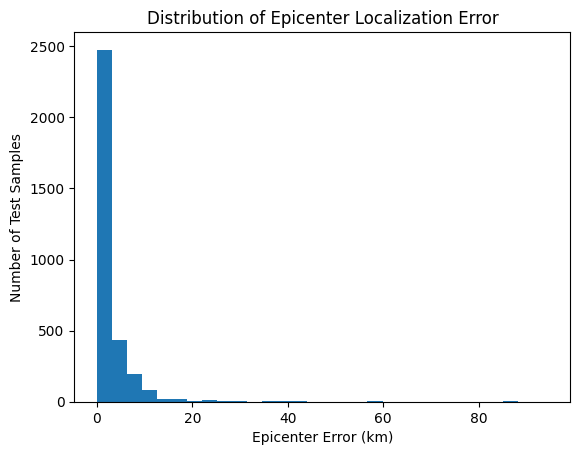

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Haversine Distance Function
# -------------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c


# -------------------------------
# Model Prediction
# -------------------------------
Y_pred = model.predict(X_test)

# -------------------------------
# Distance Error (km)
# -------------------------------
err_km = haversine(
    Y_test["eq_lat"].values,
    Y_test["eq_lon"].values,
    Y_pred[:, 0],
    Y_pred[:, 1]
)

# -------------------------------
# MAE and Other Error Metrics
# -------------------------------
mae_km = err_km.mean()              # Mean Absolute Error
median_ae = np.median(err_km)
best_error = err_km.min()
worst_error = err_km.max()

print("MAE (km):", mae_km)
print("Median Absolute Error (km):", median_ae)
print("Best Case Error (km):", best_error)
print("Worst Case Error (km):", worst_error)

# -------------------------------
# Distance-based Accuracy
# -------------------------------
threshold_km = 5   # you can also try 10 km

accuracy = np.mean(err_km <= threshold_km) * 100
print(f"Accuracy (within {threshold_km} km): {accuracy:.2f}%")

# -------------------------------
# Accuracy at Multiple Thresholds (Optional)
# -------------------------------
print("\nAccuracy at different distance thresholds:")
for t in [5, 10, 20]:
    acc = np.mean(err_km <= t) * 100
    print(f"Within {t} km: {acc:.2f}%")

# -------------------------------
# Error Distribution Plot (Optional but Recommended)
# -------------------------------
plt.figure()
plt.hist(err_km, bins=30)
plt.xlabel("Epicenter Error (km)")
plt.ylabel("Number of Test Samples")
plt.title("Distribution of Epicenter Localization Error")
plt.show()


📋 1) RESULTS TABLE (for Paper / Documentation)

In [12]:
import pandas as pd
import numpy as np

results_table = pd.DataFrame({
    "Metric": [
        "Mean Absolute Error (MAE) [km]",
        "Median Absolute Error [km]",
        "Best Case Error [km]",
        "Worst Case Error [km]",
        "Accuracy within 5 km [%]",
        "Accuracy within 10 km [%]"
    ],
    "Value": [
        err_km.mean(),
        np.median(err_km),
        err_km.min(),
        err_km.max(),
        np.mean(err_km <= 5) * 100,
        np.mean(err_km <= 10) * 100
    ]
})

results_table


,Metric,Value
0,Mean Absolute Error (MAE) [km],2.829861
1,Median Absolute Error [km],1.094279
2,Best Case Error [km],0.009226
3,Worst Case Error [km],94.511878
4,Accuracy within 5 km [%],84.232998
5,Accuracy within 10 km [%],95.364440


📊 2) ERROR DISTRIBUTION (Histogram – MUST)

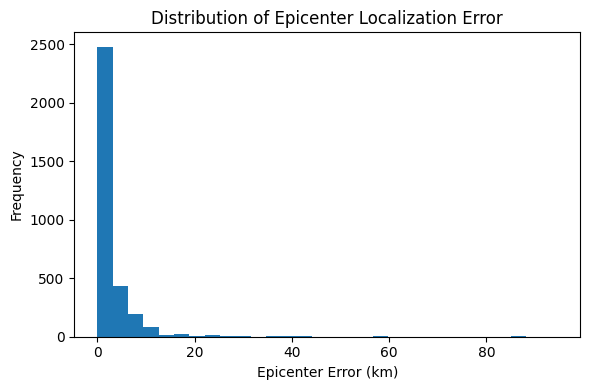

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(err_km, bins=30)
plt.xlabel("Epicenter Error (km)")
plt.ylabel("Frequency")
plt.title("Distribution of Epicenter Localization Error")
plt.tight_layout()
plt.show()


📈 3) PREDICTED vs ACTUAL (Scatter – Regression Validation)

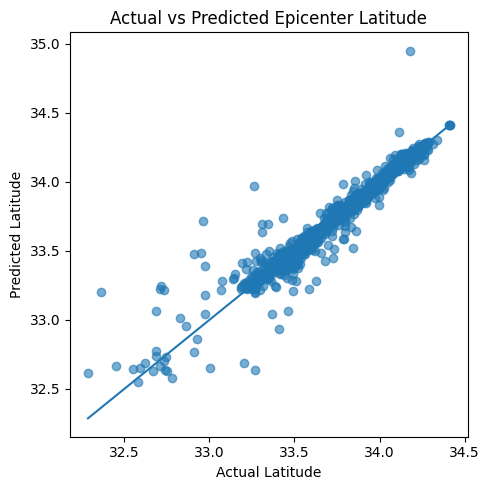

In [14]:
plt.figure(figsize=(5,5))
plt.scatter(Y_test["eq_lat"], Y_pred[:,0], alpha=0.6)
plt.xlabel("Actual Latitude")
plt.ylabel("Predicted Latitude")
plt.title("Actual vs Predicted Epicenter Latitude")
plt.plot([Y_test["eq_lat"].min(), Y_test["eq_lat"].max()],
         [Y_test["eq_lat"].min(), Y_test["eq_lat"].max()])
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(Y_test["eq_lon"], Y_pred[:,1], alpha=0.6)
plt.xlabel("Actual Longitude")
plt.ylabel("Predicted Longitude")
plt.title("Actual vs Predicted Epicenter Longitude")
plt.plot([Y_test["eq_lon"].min(), Y_test["eq_lon"].max()],
         [Y_test["eq_lon"].min(), Y_test["eq_lon"].max()])
plt.tight_layout()
plt.show()


🗺️ 4) MAP: ACTUAL vs PREDICTED EPICENTERS (VERY IMPRESSIVE)

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(Y_test["eq_lon"], Y_test["eq_lat"],
            label="Actual Epicenter", marker='o', alpha=0.6)
plt.scatter(Y_pred[:,1], Y_pred[:,0],
            label="Predicted Epicenter", marker='x', alpha=0.6)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Comparison of Actual and Predicted Epicenters")
plt.legend()
plt.tight_layout()
plt.show()


📊 5) FEATURE IMPORTANCE (Bar Chart – Interpretability)

In [ ]:
import pandas as pd

# RandomForest inside MultiOutputRegressor
rf = model.estimators_[0]
importances = rf.feature_importances_

imp_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).head(10)

plt.figure(figsize=(6,4))
plt.barh(imp_df["Feature"], imp_df["Importance"])
plt.xlabel("Importance Score")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

imp_df
